This script generates the plots to compare SCITE-RNA, DENDRO and SClineager on simulated datasets with a variable number of ground truth clones. Additionally, it plots a comparison of the runtimes.

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt

from matplotlib.font_manager import FontProperties

import matplotlib.ticker as mticker

import os
import seaborn as sns
from sklearn.metrics import adjusted_rand_score

from src_python.cell_tree import CellTree
from src_python.utils import load_config_and_set_random_seed, path_len_dist, mut_count_distance

In [2]:
path = "../data/simulated_data"
path_consensus = "../data/results"

n_cells = [50]
n_mut = [500]
n_tests = 100
clones = ["", 5, 10, 20]

n_round = 1 #

config = load_config_and_set_random_seed()

use_summary_statistics = False #True # Uses the summary files saved in the data/ directory. If raw output files were generated, set to False
genotype_differences = {"SCITE-RNA": {}}
path_len_differences = {"SCITE-RNA": {}}
mut_count_differences = {"SCITE-RNA": {}}

genotype_differences["SCITE-RNA-clustered"] = {}
path_len_differences["SCITE-RNA-clustered"] = {}
mut_count_differences["SCITE-RNA-clustered"] = {}
adjusted_rand_index= {"SCITE-RNA-clustered": {}}

path_len_differences["SCITE-RNA-consensus"] = {}

genotype_differences["SClineager"] = {}
path_len_differences["SClineager"] = {}
mut_count_differences["SClineager"] = {}
adjusted_rand_index["SClineager"] = {}

genotype_differences["DENDRO"] = {}
path_len_differences["DENDRO"] = {}
mut_count_differences["DENDRO"] = {}
adjusted_rand_index["DENDRO"] = {}

In [3]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):

        path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}

        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            mut_count_distances = []

            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")
                genotype_pred_path = os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{n_round}r{t}.txt")
                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
                genotype_gt = np.loadtxt(genotype_path, dtype=str)

                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec", f"sciterna_parent_vec_{n_round}r{t}.txt"), dtype=int)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_predicted = vectorized_map(genotype_pred)
                genotype_gt = vectorized_map(genotype_gt)
                unique_genotypes = np.unique(genotype_gt, axis=0)

                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(difference)

                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))

            path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = path_len_distances
            genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = vaf_differences
            mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(mut_count_distances), " mean mutation count distance")

2.4021714285714286  mean path length distance
0.030678799999999996  mean abs difference of vafs predicted
11.529338775510205  mean mutation count distance
4.887208163265306  mean path length distance
0.034108999999999993  mean abs difference of vafs predicted
40.69462040816327  mean mutation count distance
3.6361714285714286  mean path length distance
0.0327506  mean abs difference of vafs predicted
28.118571428571418  mean mutation count distance
2.4828979591836733  mean path length distance
0.03191580000000001  mean abs difference of vafs predicted
22.624220408163268  mean mutation count distance


In [4]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        path_len_differences["SCITE-RNA-consensus"][f"{n_c}_{n_m}"] = {}

        for clone in clones:
            path_len_distances = []

            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")
                base_path_consensus = os.path.join(path_consensus, f"{n_c}c{n_m}m{clone}")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sciterna_parent_vec = np.loadtxt(os.path.join(base_path_consensus,  "sciterna_consensus_parent_vec", f"sciterna_parent_vec_{n_round}r{t}.txt"), dtype=int)

                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))

            path_len_differences["SCITE-RNA-consensus"][f"{n_c}_{n_m}"][clone] = path_len_distances
            print(np.mean(path_len_distances), " mean path length distance")

2.2206367346938776  mean path length distance
4.076481632653061  mean path length distance
3.384653061224489  mean path length distance
2.4992897959183673  mean path length distance


In [5]:
if use_summary_statistics == False:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"] = {}
        path_len_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"] = {}
        adjusted_rand_index["SCITE-RNA-clustered"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            mut_count_distances = []
            adjusted_rand_scores = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")

                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

                if genotype_gt.ndim == 1:
                    genotype_gt = genotype_gt[:, np.newaxis]

                _, clones_gt = np.unique(genotype_gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "sciterna", "sciterna_clones", f"sciterna_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue
                adjusted_rand_scores.append(adjusted_rand_score(clones_gt, clones_pred))

                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec_clustering", f"sciterna_parent_vec_clustering_{t}.txt"), dtype=int)

                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)

                unique_classes = np.unique(clones_pred)

                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")

                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))


                genotype_predicted = np.round(vaf_observed * 2) / 2
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")

                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))


            genotype_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"][clone] = vaf_differences
            path_len_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"][clone] = path_len_distances
            mut_count_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            adjusted_rand_index["SCITE-RNA-clustered"][f"{n_c}_{n_m}"][clone] = adjusted_rand_scores
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.mean(adjusted_rand_scores), " mean adjusted rand index")

0.0675508  mean abs difference of vafs predicted
3.5893877551020403  mean path length distance
4.516865170340681  mean mutation count distance
1.0  mean adjusted rand index
0.0501416  mean abs difference of vafs predicted
4.209836734693877  mean path length distance
4.876157835671342  mean mutation count distance
0.4864087198943913  mean adjusted rand index
0.0794224  mean abs difference of vafs predicted
3.9233632653061226  mean path length distance
6.325736032064131  mean mutation count distance
0.448898661930177  mean adjusted rand index
0.09255079999999999  mean abs difference of vafs predicted
3.5360244897959183  mean path length distance
6.191681042084168  mean mutation count distance
0.4214693242006576  mean adjusted rand index


In [6]:
if use_summary_statistics == False:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        path_len_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        adjusted_rand_index["SClineager"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            mut_count_distances = []
            adjusted_rand_scores = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")

                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T
                vaf_predicted = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_vaf", f"sclineager_vaf_{t}.txt"), dtype=float).T

                if genotype_gt.ndim == 1:
                    genotype_gt = genotype_gt[:, np.newaxis]

                _, clones_gt = np.unique(genotype_gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "sclineager", "sclineager_clones", f"sclineager_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)

                adjusted_rand_scores.append(adjusted_rand_score(clones_gt, clones_pred))

                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sclineager_parent_vec = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_parent_vec", f"sclineager_parent_vec_{t}.txt"), dtype=int)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)

                genotype_predicted = np.round(vaf_predicted * 2) / 2
                if genotype_predicted.shape != genotype_gt.shape:
                    print("Cells or mutations were filtered out")
                    continue
                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_sclineager = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sclineager.use_parent_vec(sclineager_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sclineager))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))


            genotype_differences["SClineager"][f"{n_c}_{n_m}"][clone] = vaf_differences
            path_len_differences["SClineager"][f"{n_c}_{n_m}"][clone] = path_len_distances
            mut_count_differences["SClineager"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            adjusted_rand_index["SClineager"][f"{n_c}_{n_m}"][clone] = adjusted_rand_scores
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.mean(adjusted_rand_scores), " mean adjusted rand index")

Cells or mutations were filtered out
Cells or mutations were filtered out
0.06797775510204082  mean abs difference of vafs predicted
4.651453561016242  mean path length distance
4.988632775755593  mean mutation count distance
1.0  mean adjusted rand index
0.08357539999999998  mean abs difference of vafs predicted
4.515102040816327  mean path length distance
6.251465571142286  mean mutation count distance
0.32879471421472906  mean adjusted rand index
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
0.08701958762886597  mean abs difference of vafs predicted
4.575821586366505  mean path length distance
5.9921693283474164  mean mutation count distance
0.16775850098537823  mean adjusted rand index
Cells or mutations were filtered out
Cells or mutations were filtered out
0.08818346938775509  mean abs difference of vafs predicted
4.443631820074968  mean path length distance
5.905128951781113  mean mutation count distance
0.08625234

In [7]:
genotype_differences["DENDRO"] = {}
path_len_differences["DENDRO"] = {}
mut_count_differences["DENDRO"] = {}
adjusted_rand_index["DENDRO"] = {}

if use_summary_statistics == False:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        path_len_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        adjusted_rand_index["DENDRO"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            mut_count_distances = []
            adjusted_rand_scores = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")

                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

                if genotype_gt.ndim == 1:
                    genotype_gt = genotype_gt[:, np.newaxis]

                _, clones_gt = np.unique(genotype_gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "dendro", "dendro_clones", f"dendro_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue
                adjusted_rand_scores.append(adjusted_rand_score(clones_gt, clones_pred))

                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)

                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "dendro", "dendro_parent_vec", f"dendro_parent_vec_{t}.txt"), dtype=int)

                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)

                unique_classes = np.unique(clones_pred)

                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")

                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))


                genotype_predicted = np.round(vaf_observed * 2) / 2
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")

                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))


            genotype_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = vaf_differences
            path_len_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = path_len_distances
            mut_count_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            adjusted_rand_index["DENDRO"][f"{n_c}_{n_m}"][clone] = adjusted_rand_scores
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.mean(adjusted_rand_scores), " mean adjusted rand index")

0.0675508  mean abs difference of vafs predicted
4.732391836734695  mean path length distance
4.516865170340681  mean mutation count distance
1.0  mean adjusted rand index
0.0751738  mean abs difference of vafs predicted
4.659591836734694  mean path length distance
5.61423254509018  mean mutation count distance
0.23567379134374583  mean adjusted rand index
0.10883880000000003  mean abs difference of vafs predicted
4.6629632653061215  mean path length distance
6.6394586773547095  mean mutation count distance
0.09482540200326817  mean adjusted rand index
0.11349439999999998  mean abs difference of vafs predicted
4.608440816326531  mean path length distance
6.325874789579157  mean mutation count distance
0.05038498739179565  mean adjusted rand index


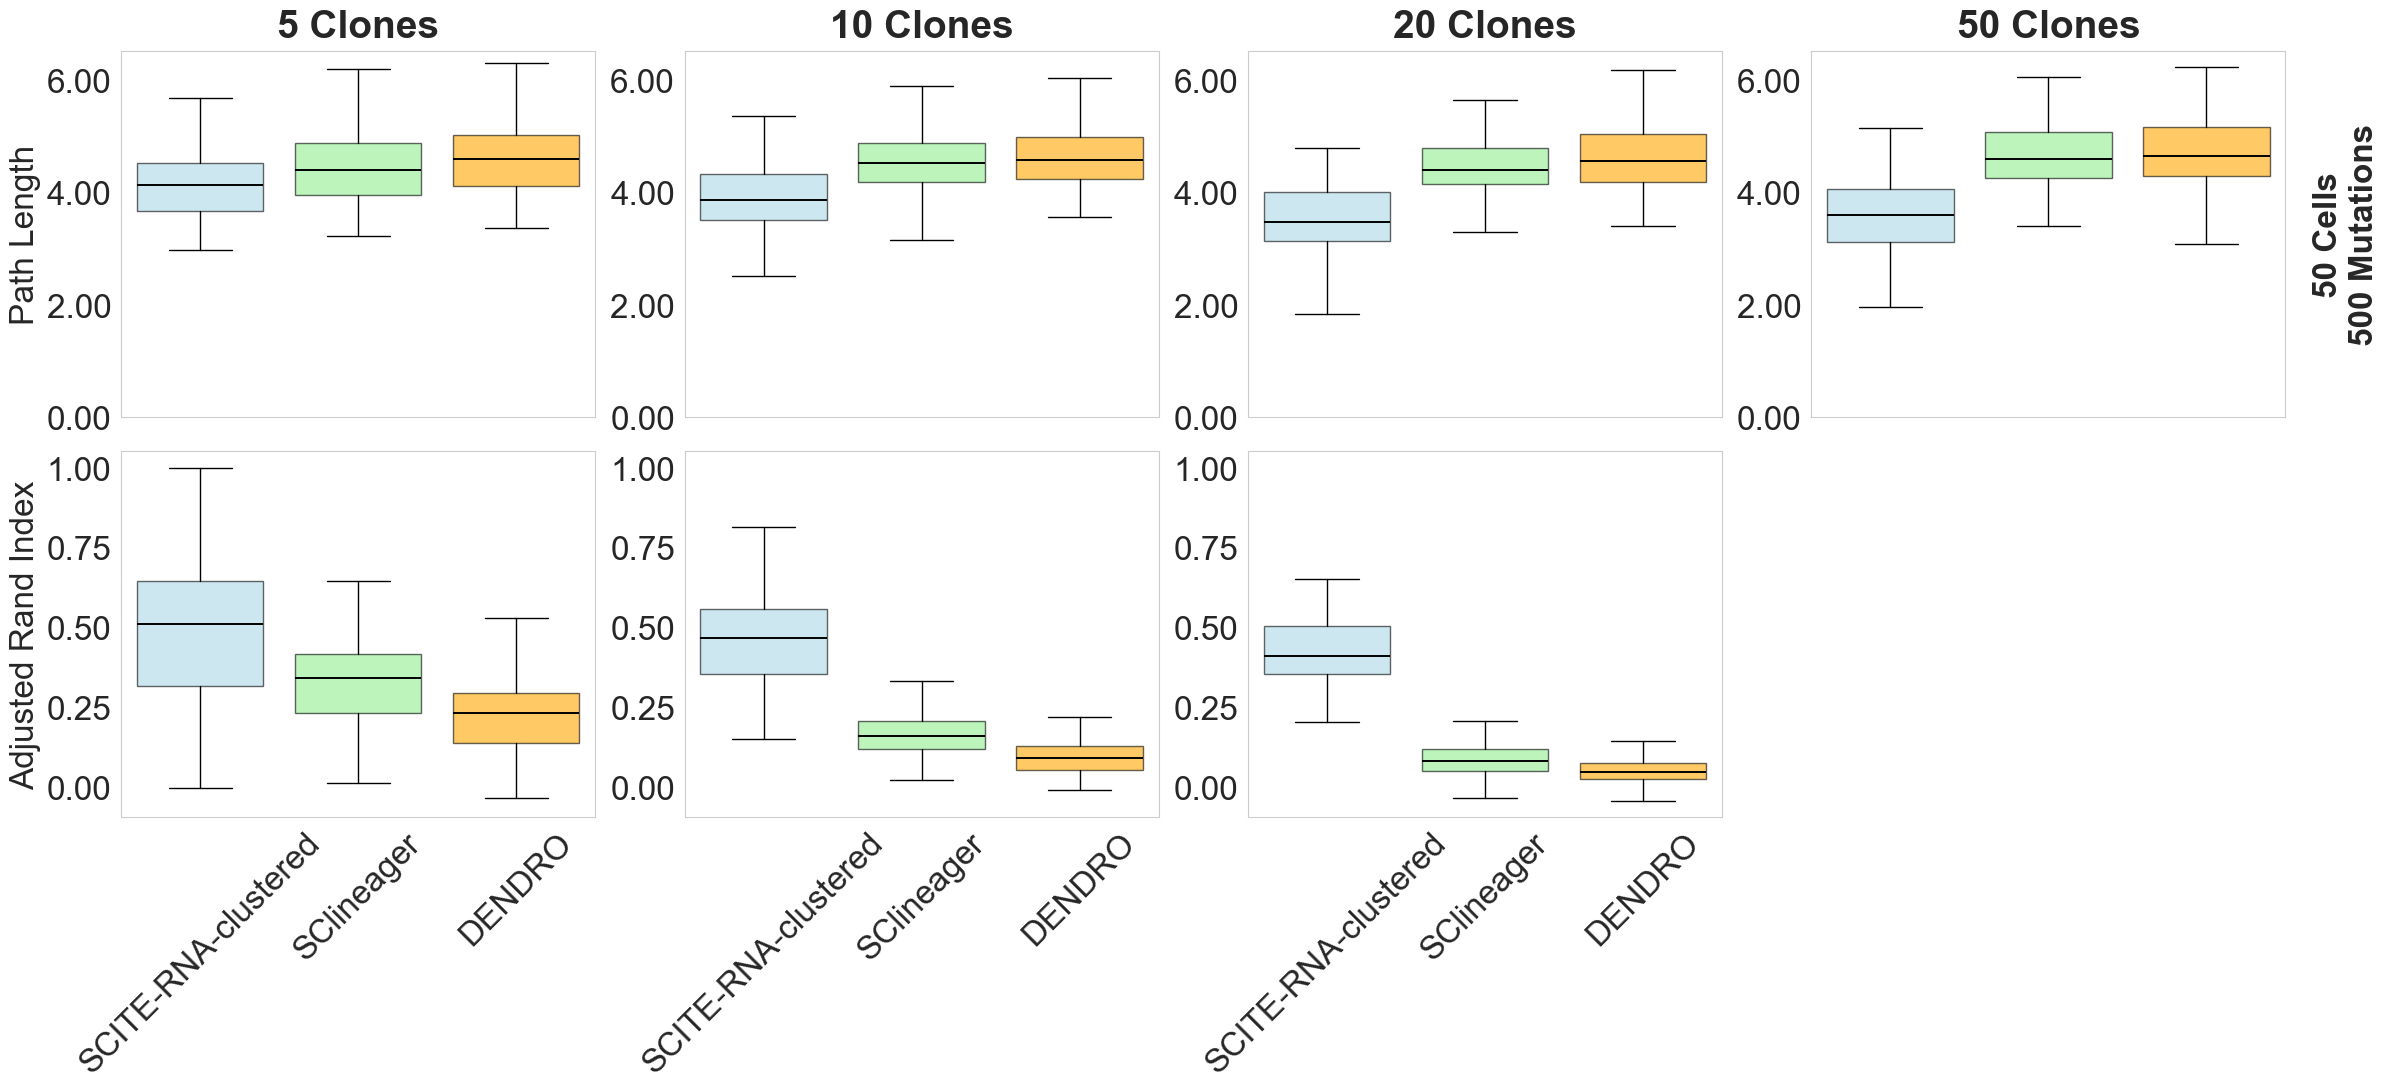

In [8]:
def plot_combined_vaf_pathlength(pathlen_data, vaf_data, clones, models=["SCITE-RNA-clustered", "SClineager", "DENDRO"]):

    n_c, n_m = 50, 500  # fixed cell and mutation counts
    rows = 2
    cols = len(clones)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows + 1), sharey=False)
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    colors = ["lightblue", "lightgreen", "orange"]
    alpha_value = 0.6

    title_size = 28
    label_size = 24
    tick_size = 24
    box_width = 1.4
    boxplot_widths = 0.8

    plot_titles = ["Path Length", "Adjusted Rand Index"]
    data_list = [pathlen_data, vaf_data]

    for row_idx, (data, plot_title) in enumerate(zip(data_list, plot_titles)):
        row_whiskers = []

        for col_idx, clone in enumerate(clones):
            sample_key = f"{n_c}_{n_m}"
            ax = axes[row_idx, col_idx]

            # Skip plotting ARI for 50 clones column
            if row_idx == 1 and clone == "":
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_frame_on(False)
                if col_idx == 0:
                    ax.set_ylabel(plot_title, fontsize=label_size)
                continue

            all_samples = [data[model][sample_key][clone] for model in models]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            if row_idx == 0:
                if clone == "":
                    ax.set_title("50 Clones", fontsize=title_size, pad=10, fontweight="bold")
                else:
                    ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == rows - 1:
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(plot_title, fontsize=label_size)
            if col_idx == cols - 1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f"{n_c} Cells\n{n_m} Mutations",
                              fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        # Apply uniform y-limits across each row (only if there is data)
        if row_whiskers:
            combined = np.concatenate(row_whiskers)
            ymin, ymax = combined.min(), combined.max()
            yrange = ymax - ymin
            ymin = min(ymin - 0.05 * yrange, 0)
            ymax += 0.05 * yrange

            if np.isfinite(ymin):
                for col_idx in range(cols):
                    if not (row_idx == 1 and clones[col_idx] == ""):
                        axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    plt.savefig("../data/results/figures/combined_PathLength_RandIndex.pdf")
    plt.show()

plot_combined_vaf_pathlength(path_len_differences, adjusted_rand_index, [5, 10, 20, ""])

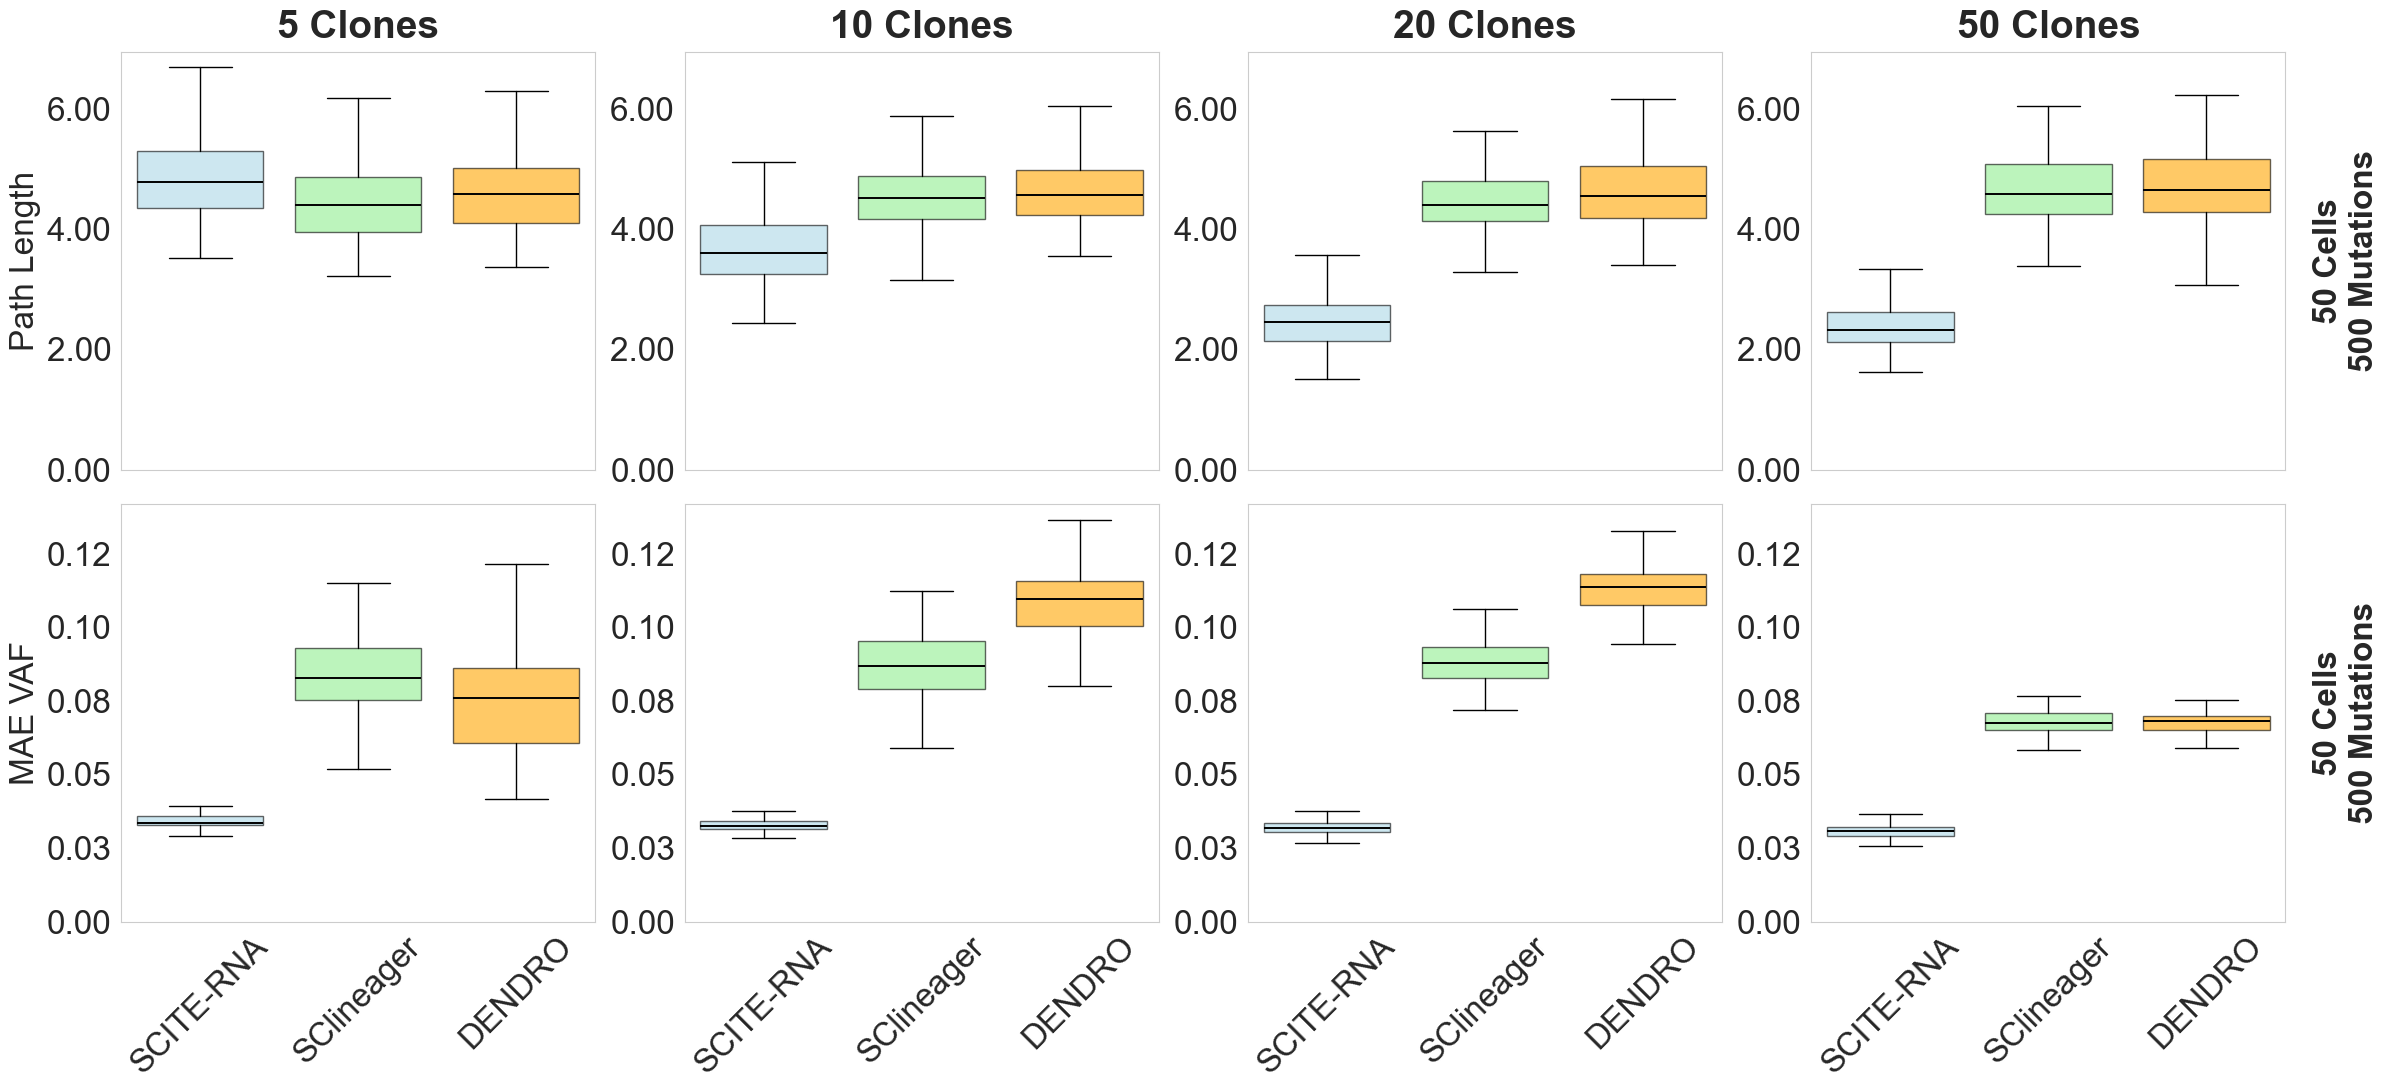

In [9]:
def plot_combined_vaf_pathlength(pathlen_data, vaf_data, clones, models=["SCITE-RNA", "SClineager", "DENDRO"]):

    n_c, n_m = 50, 500  # fixed cell and mutation counts
    rows = 2
    cols = len(clones)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows + 1), sharey=False)
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    colors = ["lightblue", "lightgreen", "orange"]
    alpha_value = 0.6

    title_size = 28
    label_size = 24
    tick_size = 24
    box_width = 1.4
    boxplot_widths = 0.8

    plot_titles = ["Path Length", "MAE VAF"]
    data_list = [pathlen_data, vaf_data]

    for row_idx, (data, plot_title) in enumerate(zip(data_list, plot_titles)):
        row_whiskers = []

        for col_idx, clone in enumerate(clones):
            sample_key = f"{n_c}_{n_m}"
            all_samples = [data[model][sample_key][clone] for model in models]

            ax = axes[row_idx, col_idx]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            if row_idx == 0:
                if clone == "":
                    ax.set_title("50 Clones", fontsize=title_size, pad=10, fontweight="bold")
                else:
                    ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == rows - 1:
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(plot_title, fontsize=label_size)
            if col_idx == cols - 1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f"{n_c} Cells\n{n_m} Mutations",
                              fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        # Apply uniform y-limits across each row
        combined = np.concatenate(row_whiskers)
        ymin, ymax = combined.min(), combined.max()
        yrange = ymax - ymin
        ymin = 0
        ymax += 0.05 * yrange

        if np.isfinite(ymin):
            for col_idx in range(cols):
                axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    plt.savefig("../data/results/figures/combined_PathLength_VAF.pdf")
    plt.show()

plot_combined_vaf_pathlength(path_len_differences, genotype_differences, [5, 10, 20, ""])

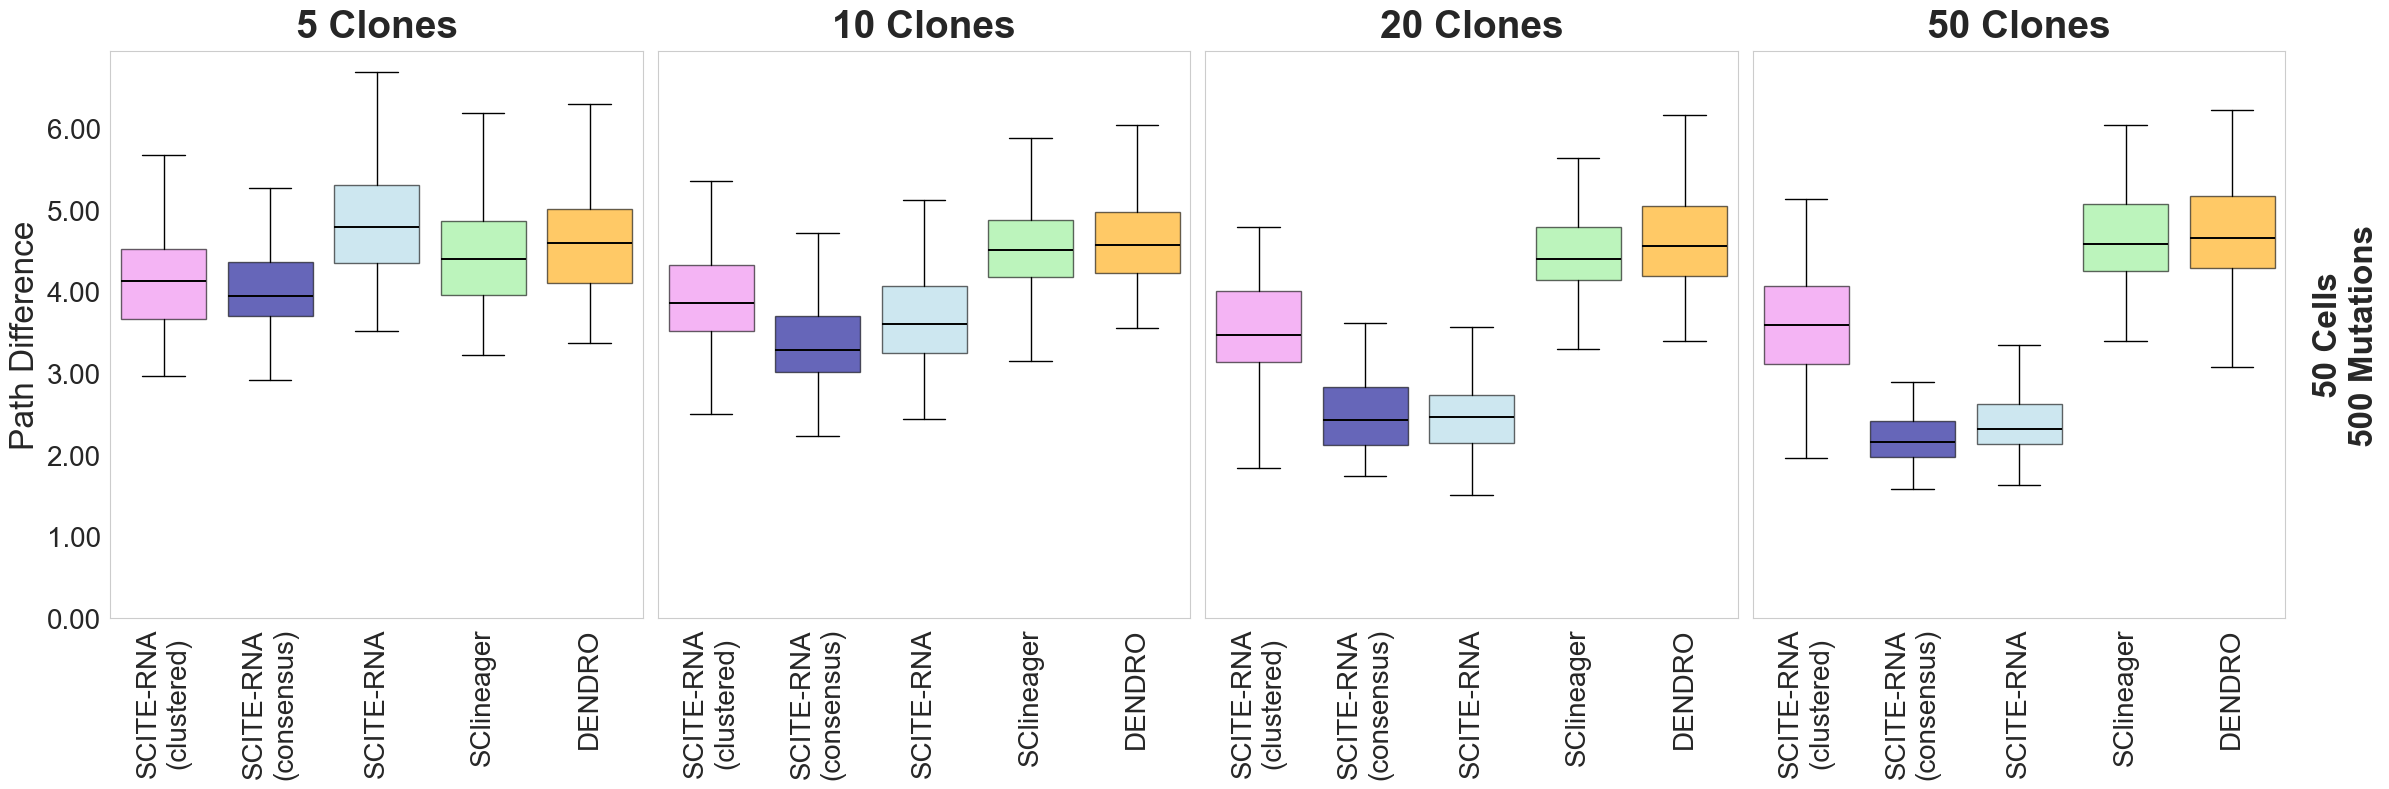

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker as mticker
from matplotlib.font_manager import FontProperties

def plot_combined_vaf_pathlength(pathlen_data, clones, models=["SCITE-RNA-clustered", "SCITE-RNA-consensus", "SCITE-RNA", "SClineager", "DENDRO"]):
    n_c, n_m = 50, 500  # fixed cell and mutation counts
    cols = len(clones)
    fig, axes = plt.subplots(1, cols, figsize=(6 * cols, 8), sharey=True)  # 1 row, `cols` columns
    if cols == 1:
        axes = np.expand_dims(axes, axis=0)  # Ensure `axes` is always 2D

    colors = ["violet", "darkblue", "lightblue", "lightgreen", "orange"]
    alpha_value = 0.6
    title_size = 28
    label_size = 24
    tick_size = 20  # Reduced for better fit
    box_width = 1.4
    boxplot_widths = 0.8

    # Collect whisker data for uniform y-axis scaling
    row_whiskers = []

    for col_idx, clone in enumerate(clones):
        sample_key = f"{n_c}_{n_m}"
        all_samples = [pathlen_data[model][sample_key][clone] for model in models]
        ax = axes[col_idx]

        # Plot boxplots
        box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(alpha_value)

        for line in box['medians']:
            line.set_linewidth(box_width)
            line.set_color("black")

        # Collect whisker data for y-axis scaling
        whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
        row_whiskers.append(whisker_data)

        # Customize x-axis labels
        custom_labels = [
            "SCITE-RNA\n(clustered)",
            "SCITE-RNA\n(consensus)",
            "SCITE-RNA",
            "SClineager",
            "DENDRO"
        ]

        ax.set_xticks(range(1, len(models) + 1))
        ax.set_xticklabels(custom_labels, fontsize=tick_size, rotation=90, ha='center', va='top')

        # Set title and labels
        if clone == "":
            ax.set_title("50 Clones", fontsize=title_size, pad=10, fontweight="bold")
        else:
            ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

        ax.tick_params(axis='y', labelsize=tick_size)
        ax.grid(False)
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        # Add y-axis label only to the first subplot
        if col_idx == 0:
            ax.set_ylabel("Path Difference", fontsize=label_size)

        # Add cell/mutation info to the last subplot
        if col_idx == cols - 1:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(f"{n_c} Cells\n{n_m} Mutations",
                          fontsize=label_size,
                          rotation=90, labelpad=20,
                          fontproperties=FontProperties(weight='bold'))

    # Set uniform y-axis limits
    combined = np.concatenate(row_whiskers)
    ymin, ymax = combined.min(), combined.max()
    yrange = ymax - ymin
    ymin = 0
    ymax += 0.05 * yrange

    for col_idx in range(cols):
        axes[col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    plt.savefig("../data/results/figures/cluster_consensus_comparison_num_clones.pdf")
    plt.show()

plot_combined_vaf_pathlength(path_len_differences, [5, 10, 20, ""])

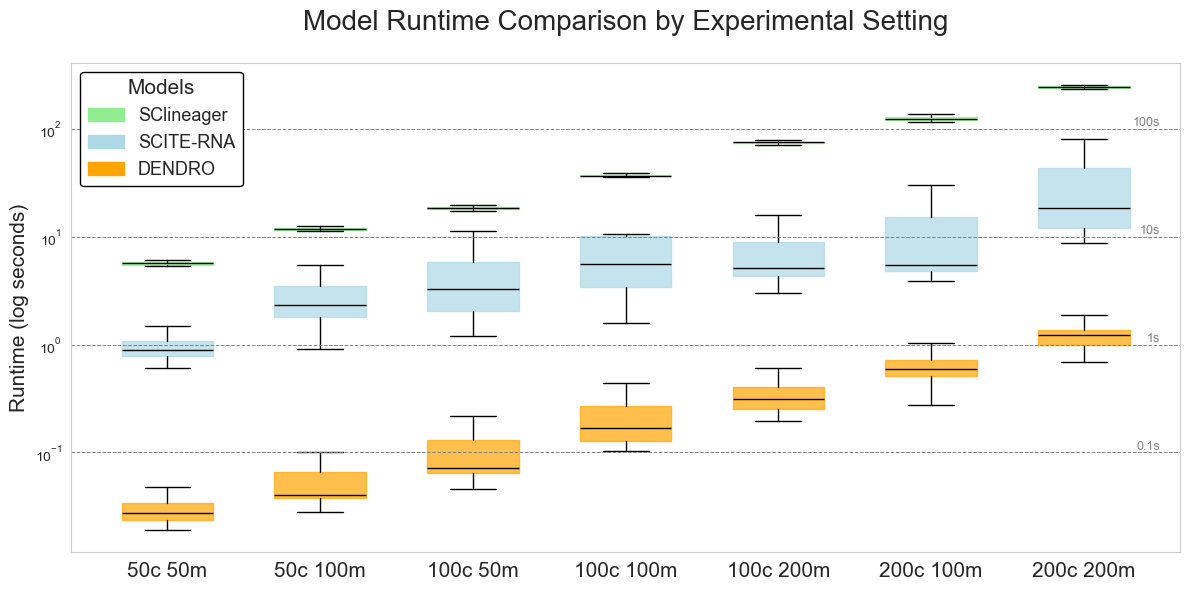

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

n_cells = [50, 50, 100, 100, 100, 200, 200]
n_mut = [50, 100, 50, 100, 200, 100, 200]
path = "../data/simulated_data/"
clone = ""

models = ["SClineager", "SCITE-RNA", "DENDRO"]
colors = ["lightgreen", "lightblue", "orange"]

# Store runtimes per model per condition
runtime_data = {model: [] for model in models}
conditions = []

# Collect runtime data
for n_c, n_m in zip(n_cells, n_mut):
    condition_label = f"{n_c}c {n_m}m"
    conditions.append(condition_label)

    base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")
    try:
        scite_rna = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_runtimes.txt"))
        sclineager = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_runtimes.txt"))
        dendro = np.loadtxt(os.path.join(base_path, "dendro", "dendro_runtimes.txt"))
    except Exception as e:
        print(f"Error loading data for {condition_label}: {e}")
        continue

    runtime_data["SCITE-RNA"].append(scite_rna)
    runtime_data["SClineager"].append(sclineager)
    runtime_data["DENDRO"].append(dendro)

fig, ax = plt.subplots(figsize=(12, 6))

positions = []
box_data = []
group_spacing = 2
box_width = 1.2

tick_positions = []
tick_labels = []

# Organize data for plotting
for idx, condition in enumerate(conditions):
    group_positions = []
    for offset, model in enumerate(models):
        pos = idx * group_spacing # + offset
        positions.append(pos)
        group_positions.append(pos)
        box_data.append(runtime_data[model][idx])

    tick_center = np.mean(group_positions)
    tick_positions.append(tick_center)
    tick_labels.append(condition)

# Plot boxplots
box = ax.boxplot(box_data, positions=positions, widths=box_width, patch_artist=True, showfliers=False)

# Color boxes
for patch, color in zip(box["boxes"], [colors[i % 3] for i in range(len(box_data))]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    patch.set_alpha(0.7)

# Style medians
for line in box['medians']:
    line.set_color("black")
    line.set_linewidth(1.0)

# Axis formatting
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, ha='center', fontsize=15)
ax.set_ylabel("Runtime (log seconds)", fontsize=15)
ax.set_title("Model Runtime Comparison by Experimental Setting", fontsize=20, y=1.05)
ax.set_yscale("log")
ax.grid(False)

reference_lines = [0.1, 1, 10, 100]
for y in reference_lines:
    ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.7)
    ax.text(len(conditions)*group_spacing - 1, y, f'{y}s', va='bottom', ha='right', fontsize=9, color='gray', zorder=1)

# Add legend
legend_patches = [Patch(facecolor=colors[i], edgecolor=colors[i], label=models[i]) for i in range(len(models))]
ax.legend(handles=legend_patches, title="Models", loc='upper left', fontsize=13, title_fontsize=15, facecolor='white', framealpha=1.0, edgecolor='black')

plt.tight_layout()
plt.savefig("../data/results/figures/model_runtime_comparison.pdf")
plt.show()